# Voting History

## Python setup

In [1]:
# data science imports
import pathlib
from io import StringIO

import pandas as pd
import numpy as np
import mgplot as mg
import matplotlib.pyplot as plt

In [2]:
# local imports
from common import COLOR_COALITION, COLOR_LABOR, RFOOTER
LFOOTER = "Australia. Data sourced from the Australian Electoral Commission. "

In [3]:
# plotting setup
def set_up_plotting() -> None:
    """Set up plotting."""
    mg.set_chart_dir("../charts/previous-elections/")
    mg.clear_chart_dir()


set_up_plotting()
SHOW = True

## Data

In [4]:
HISTORY = "../historic-data/election-outcomes.csv"
table = pd.read_csv(
    HISTORY,
    header=0,
    index_col=0,
    sep=r'\s+',  # Updated to fix deprecation warning
    comment="#",
    na_values="-",
    parse_dates=["Date"],
)

In [5]:
coalition = ["LP", "LNP", "NP", "CLP"]
e_others = ["DLP", "DEM", "GRN", "ON", "UAP", "Others"]
primary = ["ALP", "LP", "LNP", "NP", "CLP", "DLP", "DEM", "GRN", "ON", "UAP", "Others"]

In [6]:
# quick data consistency checks
assert table.index.is_monotonic_increasing
row_sums = table[primary].sum(axis=1, skipna=True)
assert (row_sums >= 99.8).all() and (row_sums <= 100.2).all()
assert (table["ALP"] < table["Labor2pp"]).all()
assert len(table["GovtBefore"].unique()) == 2
assert len(table["GovtAfter"].unique()) == 2
assert (table["Date"].dt.year == table.index).all()

## Historical plots

### Minor parties

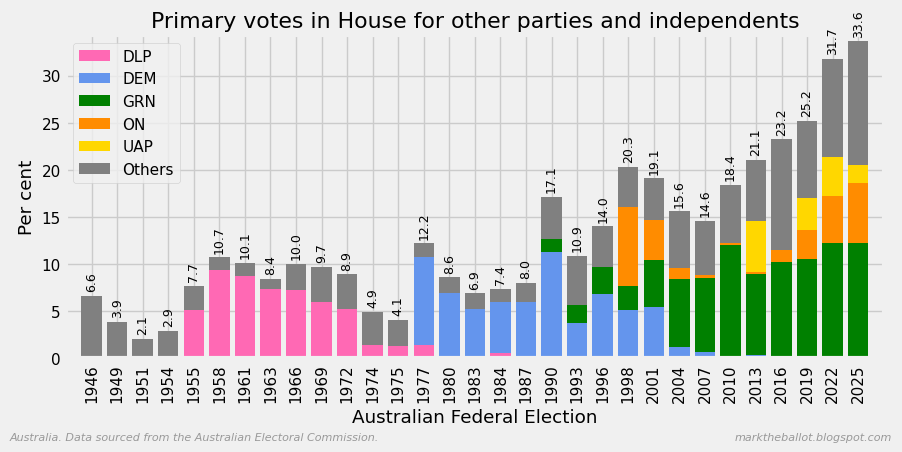

In [7]:
colors = ["hotpink", "cornflowerblue", "green", "darkorange", "gold", "grey"]

fig, ax = plt.subplots()
stacked_bars = table[e_others].plot.bar(
    stacked=True,
    ax=ax,
    width=0.8,
    color=colors,
)

# Add total labels above each stacked bar
for i, (idx, row) in enumerate(table[e_others].iterrows()):
    total = row.sum()
    ax.text(i, total + 0.5, f'{total:.1f}', 
            ha='center', va='bottom', rotation=90, fontsize=9, color='black')

mg.finalise_plot(
    ax,
    title="Primary votes in House for other parties and independents",
    xlabel="Australian Federal Election",
    ylabel="Per cent",
    lfooter=LFOOTER,
    rfooter=RFOOTER,
    show=SHOW,
)

### Mainstream parties

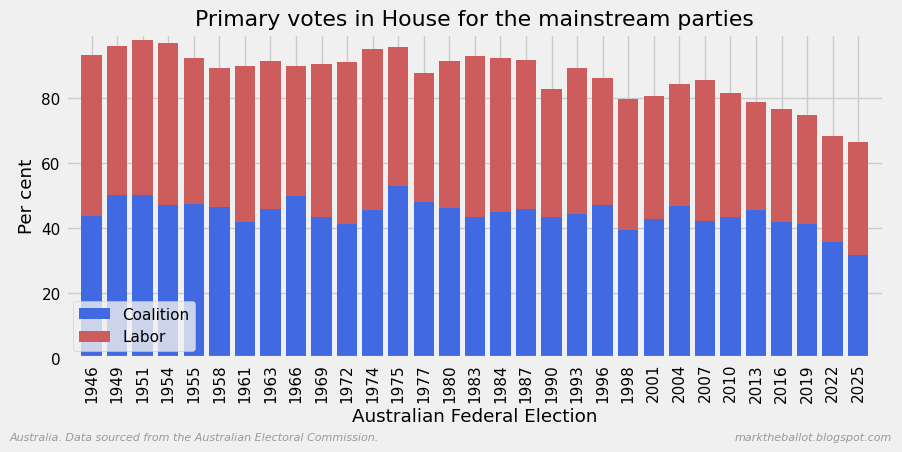

In [8]:
mainstream = table.copy()
mainstream["Coalition"] = mainstream[coalition].sum(axis=1)
mainstream = mainstream.rename(columns={"ALP": "Labor"})
majors = ["Coalition", "Labor"]

fig, ax = plt.subplots()
mainstream[majors].plot.bar(
    stacked=True, 
    ax=ax, 
    width=0.8, 
    color=[COLOR_COALITION, COLOR_LABOR]
)

mg.finalise_plot(
    ax,
    title="Primary votes in House for the mainstream parties",
    xlabel="Australian Federal Election",
    ylabel="Per cent",
    legend={"loc": "lower left"},
    rfooter=RFOOTER,
    lfooter=LFOOTER,
    show=SHOW,
)

### Election cycles

In [9]:
def add_government(from_table, start, ending, to_cycles, colors, markers):
    name = f"{start}-{ending}"
    selection = from_table.index[
        (from_table.index >= start) & (from_table.index <= ending)
    ]
    dates = from_table.loc[selection].Date
    values = from_table.loc[selection].Labor2pp
    if from_table.at[start, "GovtAfter"] == "Coalition":
        values = 100 - values
        colors[name] = COLOR_COALITION
        markers[name] = MARKER_COALITION
    else:
        colors[name] = COLOR_LABOR
        markers[name] = MARKER_LABOR
    values.index = dates
    to_cycles[name] = values

In [10]:
# identify changes of government at an election ...
changes = table["GovtBefore"] != table["GovtAfter"]
change_points = changes[changes].index.values
final = table.index[-1]
if final not in change_points:
    change_points = np.append(change_points, table.index[-1])


# construct separate runs for each government
MARKER_LABOR, MARKER_COALITION = "o", "s"
cycles = pd.DataFrame(index=table.Date)
colors = {}
markers = {}

start = table.index[0]
for ending in change_points:
    add_government(table, start, ending, cycles, colors, markers)
    start = ending

# special case - newly elected government
if table.index[-1] in change_points:
    add_government(table, start, ending, cycles, colors, markers)

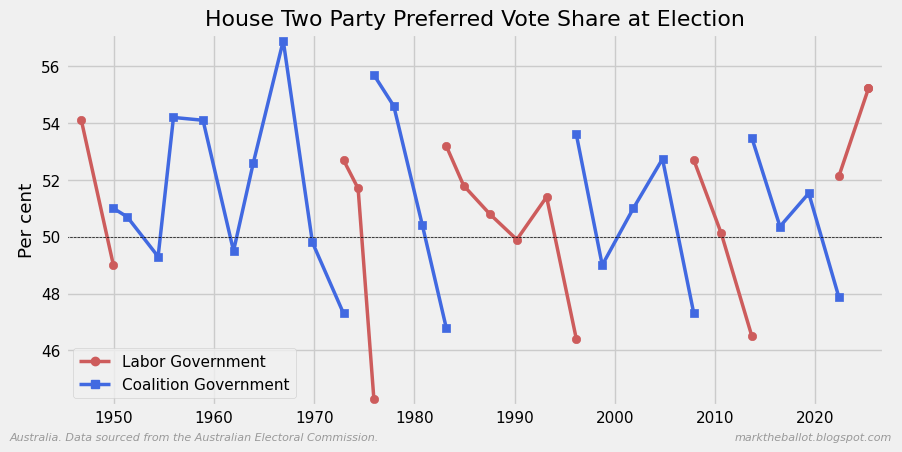

In [11]:
# plot these government cycles
LW = 2.5
MARKER_LABOR, MARKER_COALITION = "o", "s"

fig, ax = plt.subplots()

# Plot lines and scatter points
for column in cycles.columns:
    cycles[column].plot.line(ax=ax, c=colors[column], linewidth=LW)
    ax.scatter(
        cycles.index, cycles[column], marker=markers[column], color=colors[column]
    )

# custom legend
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color=COLOR_LABOR, lw=LW, marker=MARKER_LABOR),
    Line2D([0], [0], color=COLOR_COALITION, lw=LW, marker=MARKER_COALITION),
]
ax.legend(custom_lines, ["Labor Government", "Coalition Government"])

# set x-axis label formatting
ax.tick_params(axis='x', rotation=0)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')

# finalise plot with mgplot
mg.finalise_plot(
    ax,
    xlabel=None,
    ylabel="Per cent",
    rfooter=RFOOTER,
    lfooter=LFOOTER,
    axhline={"y": 50, "color": "black", "linestyle": "--", "linewidth": 0.5},
    title="House Two Party Preferred Vote Share at Election",
    show=SHOW,
)

### Preference flows

Found 8 preference files: ['2019-two-party-preferred-flow-by-party.csv', '2007-two-party-preferred-flow-by-party.csv', '2004-two-party-preferred-flow-by-party.csv', '2016-two-party-preferred-flow-by-party.csv', '2022-two-party-preferred-flow-by-party.csv', '2025-two-party-preferred-flow-by-party.csv', '2013-two-party-preferred-flow-by-party.csv', '2010-two-party-preferred-flow-by-party.csv']
Processed 2004: Green=0.808, Other=0.442
Processed 2007: Green=0.797, Other=0.446
Processed 2010: Green=0.788, Other=0.417
Processed 2013: Green=0.830, Other=0.467
Processed 2016: Green=0.819, Other=0.492
Processed 2019: Green=0.822, Other=0.437
Processed 2022: Green=0.857, Other=0.464
Processed 2025: Green=0.882, Other=0.459


,Green,Other
2004,80.793220,44.195436
2007,79.688341,44.625417
2010,78.843288,41.736056
2013,83.031521,46.688419
2016,81.938946,49.246910
2019,82.208786,43.726802
2022,85.658789,46.365604
2025,88.194248,45.862372


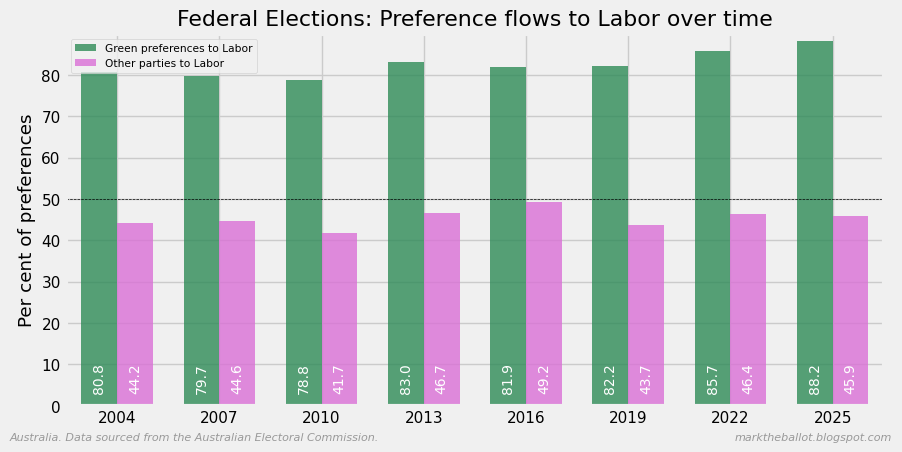

In [12]:
def pflows() -> None:
    """Preference flows at recent elections."""

    directory_path = pathlib.Path("../historic-data/preferences")
    
    # Check if directory exists
    if not directory_path.exists():
        print(f"Warning: Preferences directory not found: {directory_path}")
        print("Skipping preference flows analysis.")
        return
    
    # Only process the main preference flow files (not state-by-state files)
    files = list(directory_path.glob('*two-party-preferred-flow-by-party.csv'))
    
    # Check if any CSV files found
    if not files:
        print(f"Warning: No preference flow CSV files found in {directory_path}")
        print("Skipping preference flows analysis.")
        return
    
    print(f"Found {len(files)} preference files: {[f.name for f in files]}")
    
    results = []
    for file in sorted(files):
        try:
            year = file.stem.split("-")[0]
            frame = pd.read_csv(
                file, 
                comment="#",
                sep=",",
                header=0,
                index_col=0,
                na_values="-", 
            )
            frame = frame.dropna(how='all', axis=1)
            frame = frame.dropna(how='all', axis=0)
            frame = frame[frame.index.notna()]
            
            # Handle different column name patterns across elections
            # Find the Labor and Coalition transfer vote columns
            labor_votes_col = None
            coalition_votes_col = None
            
            for col in frame.columns:
                if 'Australian Labor Party Transfer Votes' in col:
                    labor_votes_col = col
                elif 'Liberal/National Coalition Transfer Votes' in col:
                    coalition_votes_col = col
            
            if not labor_votes_col or not coalition_votes_col:
                print(f"Warning: Could not find required columns in {file.name}")
                print(f"Available columns: {frame.columns.tolist()}")
                continue
            
            # Calculate row sums for transfers
            row_sums = frame[coalition_votes_col] + frame[labor_votes_col]
            
            # Get Green preference flow to Labor (handle if GRN doesn't exist)
            if 'GRN' in frame.index:
                green = frame.loc['GRN', labor_votes_col] / row_sums['GRN']
            else:
                print(f"Warning: No GRN data found in {year}")
                green = 0.0
            
            # Remove major parties and calculate other parties flow
            frame = frame.drop(labels=['GRN', 'LP', 'NP'], errors='ignore')
            other = (
                frame[labor_votes_col].sum() / 
                (frame[labor_votes_col].sum() + frame[coalition_votes_col].sum())
            )
            
            series = pd.Series([green, other], index=['Green', 'Other'])
            series.name = year
            results.append(series)
            print(f"Processed {year}: Green={green:.3f}, Other={other:.3f}")
            
        except Exception as e:
            print(f"Warning: Error processing file {file.name}: {e}")
            continue

    # Check if we have any results to plot
    if not results:
        print("Warning: No valid preference data found. Skipping chart creation.")
        return
        
    df = pd.concat(results, axis=1).T * 100
    df = df.sort_index()  # Sort by year
    display(df)
    
    # Use matplotlib bar plot with mgplot finalizing
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create grouped bar chart
    width = 0.35
    x = range(len(df.index))
    
    bars1 = ax.bar([i - width/2 for i in x], df['Green'], width, label='Green preferences to Labor', color='seagreen', alpha=0.8)
    bars2 = ax.bar([i + width/2 for i in x], df['Other'], width, label='Other parties to Labor', color='orchid', alpha=0.8)
    
    # Add value labels on bars with rotation=90
    placement = 3
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Green bar labels
        height1 = bar1.get_height()
        ax.text(bar1.get_x() + bar1.get_width()/2., placement,
                f'{height1:.1f}', ha='center', va='bottom', rotation=90, fontsize=10,
                color='white')

        # Other bar labels  
        height2 = bar2.get_height()
        ax.text(bar2.get_x() + bar2.get_width()/2., placement,
                f'{height2:.1f}', ha='center', va='bottom', rotation=90, fontsize=10,
                color='white')
    
    # Set x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=0)
    
    mg.finalise_plot(
        ax,
        title="Federal Elections: Preference flows to Labor over time",
        ylabel="Per cent of preferences",
        xlabel=None,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        axhline={"y": 50, "color": "black", "linestyle": "--", "linewidth": 0.5},
        legend=True,
        show=SHOW,
    )


pflows()

## The End

In [13]:
%load_ext watermark
%watermark --python --machine --conda --iversion --watermark

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

matplotlib: 3.10.3
numpy     : 2.3.1
pandas    : 2.3.1
pathlib   : 1.0.1
mgplot    : 0.2.11

Watermark: 2.5.0



In [14]:
print("It is done")

It is done
